In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os, scipy
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as pyplot
# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri
import rpy2.robjects.numpy2ri
#import numpy2ri

pandas2ri.activate()
anndata2ri.activate()
rpy2.robjects.numpy2ri.activate()

%load_ext rpy2.ipython

# d50-70 all cells integration and annotation

In [2]:
adata_concat = sc.read('Data/adata_concat.h5ad')
adata_d50_d70 = adata_concat[adata_concat.obs['day'].isin(['D50','D70'])]

In [3]:
%%R -i adata_d50_d70 -o adata_integrated -o umap_emb -o pca_emb -o hvg_list

Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(dplyr)

sobj <- as.Seurat(adata_d50_d70, counts = "counts", data = NULL)

sobj_list <- SplitObject(sobj, split.by = 'reactionID')

sobj_list <- lapply(X = sobj_list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 3000)
})

features <- SelectIntegrationFeatures(object.list = sobj_list, nfeatures = 3000)

sobj_list <- lapply(X = sobj_list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
  })

anchors <- FindIntegrationAnchors(object.list = sobj_list, anchor.features = features, reduction = "rpca")
sobj <- IntegrateData(anchorset = anchors,k.weight=60)
DefaultAssay(sobj) <- "integrated"
sobj <- ScaleData(sobj) %>% RunPCA(.)
sobj <- RunUMAP(sobj, dims = 1:40)
sobj <- FindNeighbors(sobj, dims = 1:40)
sobj <- FindClusters(sobj,resolution=0.10)

pca_emb = Embeddings(object = sobj, reduction = "pca")
hvg_list = rownames(sobj)

DefaultAssay(sobj) <- "originalexp"

umap_emb = Embeddings(object = sobj, reduction = "umap")
adata_integrated = as.SingleCellExperiment(sobj) 

saveRDS(sobj,'Data/d50_d70_global_seurat.rds')


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
     |                                                  | 0 % ~calculating   |+++                                               | 6 % ~17s           |++++++                                            | 12% ~17s           |+++++++++                                         | 18% ~14s           |++++++++++++                                      | 24% ~12s           |+++++++++++++++                                   | 29% ~11s           |++++++++++++++++++                                | 35% ~10s           |+++++++++++++++++++++                             | 41% ~08s           |++++++++++++++++++++++++                          | 47% ~07s           |+++++++++++++++++++++++++++                       | 53% ~06s           |++++++++++++++++++++++++++++++                    | 59% ~05s           |++++++++++++

Attaching SeuratObject

Attaching package: ‘Seurat’

The following object is masked from ‘package:SummarizedExperiment’:

    Assays


Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union

The following object is masked from ‘package:GenomeInfoDb’:

    intersect

The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union

The following object is masked from ‘package:matrixStats’:

    count

The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Performing log-normalizati

In [4]:
adata_d50_d70.obsm['X_umap'] = umap_emb
adata_d50_d70.obsm['X_pca'] = pca_emb
adata_d50_d70.var['highly_variable'] = adata_d50_d70.var.index.isin(hvg_list)

adata_d50_d70.obs['integrated_snn_res.0.1'] = adata_integrated.obs['integrated_snn_res.0.1']


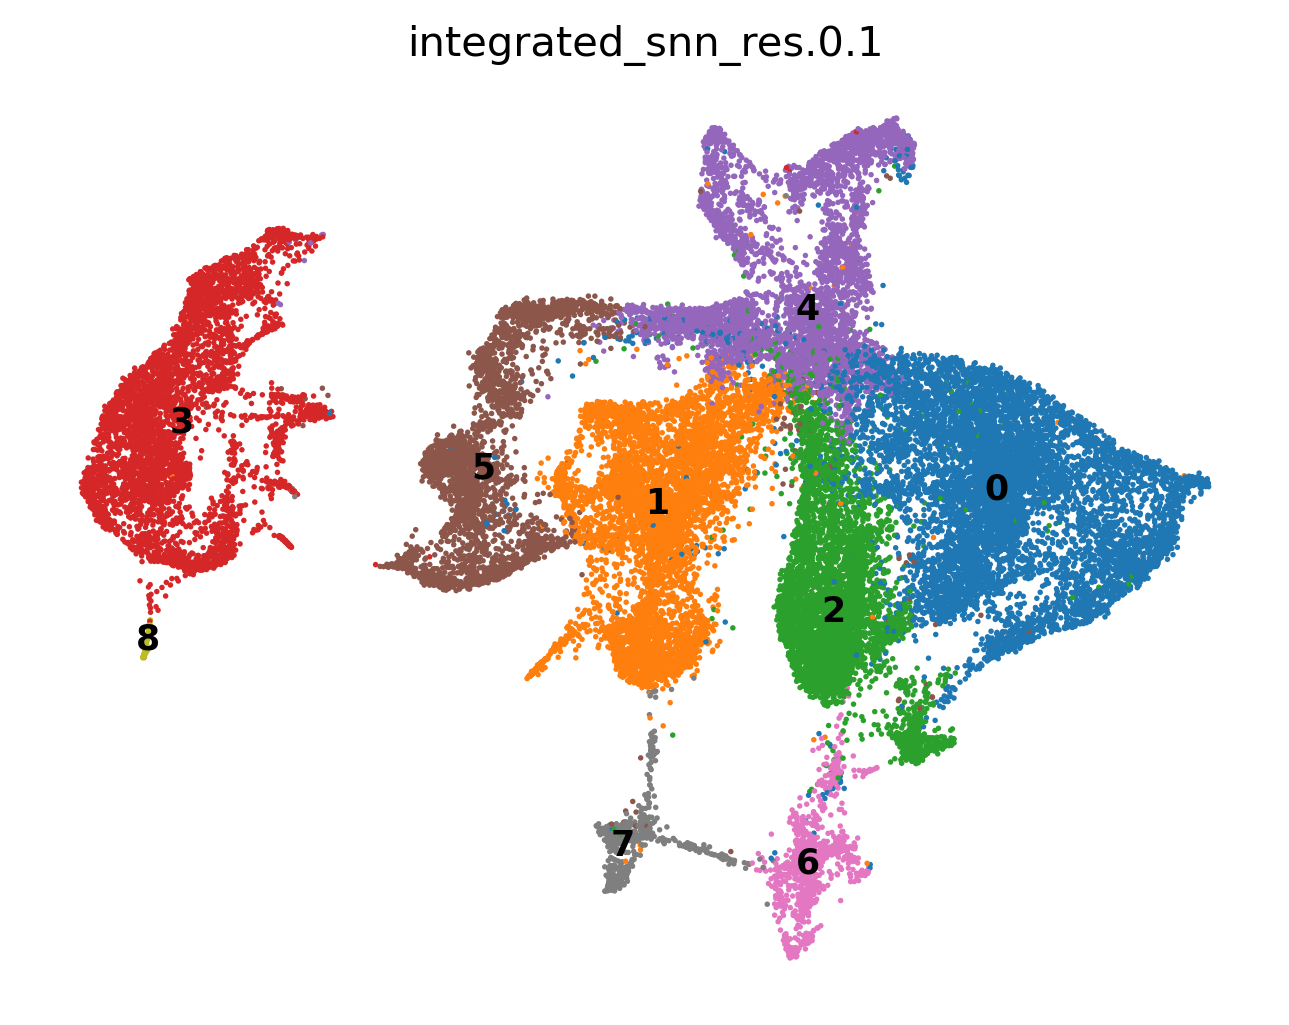

In [6]:
with plt.rc_context({ "figure.dpi": 250}):
    sc.pl.umap(adata_d50_d70, color=['integrated_snn_res.0.1'],legend_loc='on data',
    use_raw=False, size=10,frameon=False,  ncols=3,cmap='jet', colorbar_loc=None,wspace=-0.05)

In [7]:
adata_d50_d70.obs['Cell_types'] = 'Unassigned'

arc = pd.Series(list(adata_d50_d70[adata_d50_d70.obs["integrated_snn_res.0.1"].isin(['0','1','2','4','6'])].obs.index), dtype="category")
adata_d50_d70.obs["Cell_types"].loc[arc] = "ARC neurons"

tele = pd.Series(list(adata_d50_d70[adata_d50_d70.obs["integrated_snn_res.0.1"].isin(['7'])].obs.index), dtype="category")
adata_d50_d70.obs["Cell_types"].loc[tele] = "Telencephalic neurons"

arc_imm = pd.Series(list(adata_d50_d70[adata_d50_d70.obs["integrated_snn_res.0.1"].isin(['5'])].obs.index), dtype="category")
adata_d50_d70.obs["Cell_types"].loc[arc_imm] = "Immature ARC neurons"

tany = pd.Series(list(adata_d50_d70[adata_d50_d70.obs["integrated_snn_res.0.1"].isin(['3','8'])].obs.index), dtype="category")
adata_d50_d70.obs["Cell_types"].loc[tany] = "Tanycytes"


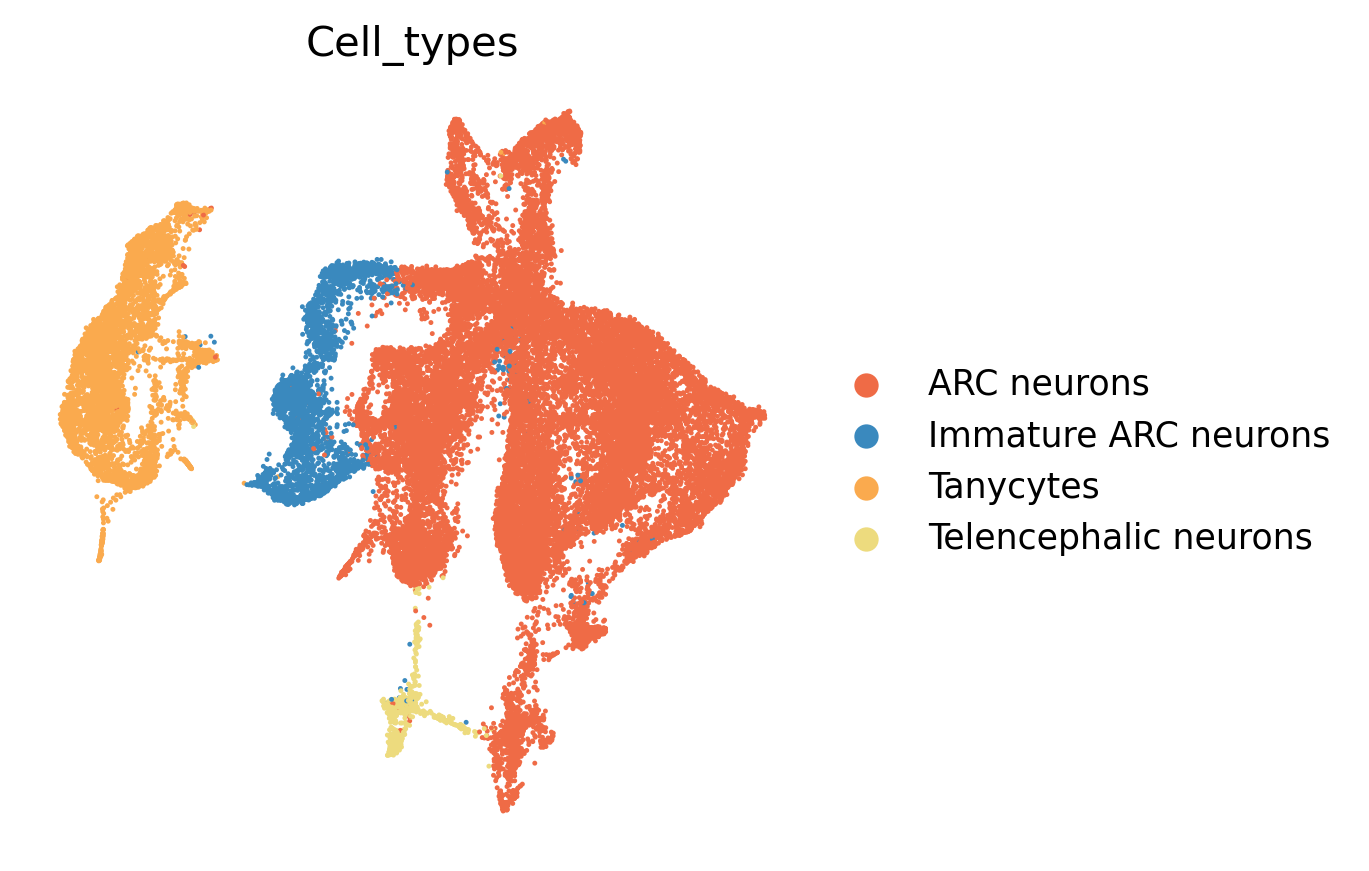

In [75]:
with plt.rc_context({ "figure.dpi": 250, "figure.figsize": (4,4)}):
    sc.pl.umap(adata_d50_d70, color=['Cell_types'], use_raw=False, size=8,frameon=False,
               ncols=1,palette=['#EF6B46','#3A89BE','#FAAA4E','#EDDB7E','#E73F3F'], colorbar_loc=None)

In [ ]:
adata_d50_d70.write('Data/adata_d50_d70.h5ad')

# Neurons d50_d70 integration and annotation

In [2]:
adata_d50_d70 = sc.read('Data/adata_d50_d70.h5ad')
adata_neurons = adata_d50_d70[adata_d50_d70.obs['Cell_types'].isin(['ARC neurons'])]

# Keep only batches with sufficient number of cells
adata_neurons = adata_neurons[adata_neurons.obs['reactionID'].isin(['H1', 'G1', 'C2', 'F2', 'D2', 'E2', 'G2', 'H2', 'B6', 'A11',
                  'A6', 'A7', 'B5', 'A9', 'B8', 'B7'])]

In [ ]:
%%R -i adata_neurons -o adata_integrated -o umap_emb -o pca_emb -o hvg_list

Csparse_validate = "CsparseMatrix_validate"
library(Seurat)
library(dplyr)

sobj <- as.Seurat(adata_neurons, counts = "counts", data = NULL)

sobj_list <- SplitObject(sobj, split.by = 'reactionID')

sobj_list <- lapply(X = sobj_list, FUN = function(x) {
    x <- NormalizeData(x)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 3000)
})

features <- SelectIntegrationFeatures(object.list = sobj_list,nfeatures = 3000)

sobj_list <- lapply(X = sobj_list, FUN = function(x) {
    x <- ScaleData(x, features = features, verbose = FALSE)
    x <- RunPCA(x, features = features, verbose = FALSE)
  })

anchors <- FindIntegrationAnchors(object.list = sobj_list, anchor.features = features, reduction = "rpca")
sobj <- IntegrateData(anchorset = anchors,k.weight=60)
DefaultAssay(sobj) <- "integrated"
sobj <- ScaleData(sobj) %>% RunPCA(.)
sobj <- RunUMAP(sobj, dims = 1:50)
sobj <- FindNeighbors(sobj, dims = 1:50)
sobj <- FindClusters(sobj,resolution=0.25)
sobj <- FindClusters(sobj,resolution=0.75)

pca_emb = Embeddings(object = sobj, reduction = "pca")
hvg_list = rownames(sobj)

DefaultAssay(sobj) <- "originalexp"

umap_emb = Embeddings(object = sobj, reduction = "umap")
adata_integrated = as.SingleCellExperiment(sobj) 

saveRDS(sobj,'Data/d50_d70_neurons_seurat.rds')

In [7]:
adata_neurons.obsm['X_umap'] = umap_emb
adata_neurons.obsm['X_pca'] = pca_emb
adata_neurons.var['highly_variable'] = adata_neurons.var.index.isin(hvg_list)
adata_neurons.obs['integrated_snn_res.0.25'] = adata_integrated.obs['integrated_snn_res.0.25']
adata_neurons.obs['integrated_snn_res.0.75'] = adata_integrated.obs['integrated_snn_res.0.75']

In [7]:
adata_neurons.obs['Cell_types'] = 'Unassigned'

agrp_sst = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['4'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[agrp_sst] = "AGRP+/SST+"

nr5a2_onecut = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['7'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[nr5a2_onecut] = "NR5A2+/ONECUT1/3+"

pomc_prdm12 = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['1'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[pomc_prdm12] = "POMC+/PRDM12+/LEPR+"

unc13c_otp = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['6'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[unc13c_otp] = "UNC13C+/OTP+"

pomc_nr5a2 = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['10'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[pomc_nr5a2] = "POMC+/NR5A2+/TRH+"

pcsk1_adgrl4 = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['0'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[pcsk1_adgrl4] = "PCSK1+/ADGRL4+"

pnoc_tac3 = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['5'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[pnoc_tac3] = "PNOC+/TAC3+"

pnoc_ghrh = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['13'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[pnoc_ghrh] = "GHRH+/PNOC+"

pomc_grabp1 = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['8','11'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[pomc_grabp1] = "POMC+/CRABP1+/TRH+"
                                                                                              
dlx6_foxp2 = pd.Series(list(adata_neurons[adata_neurons.obs["integrated_snn_res.0.25"].isin(['2','12'])].obs.index), dtype="category")
adata_neurons.obs["Cell_types"].loc[dlx6_foxp2] = "DLX6-AS1+/FOXP2+"

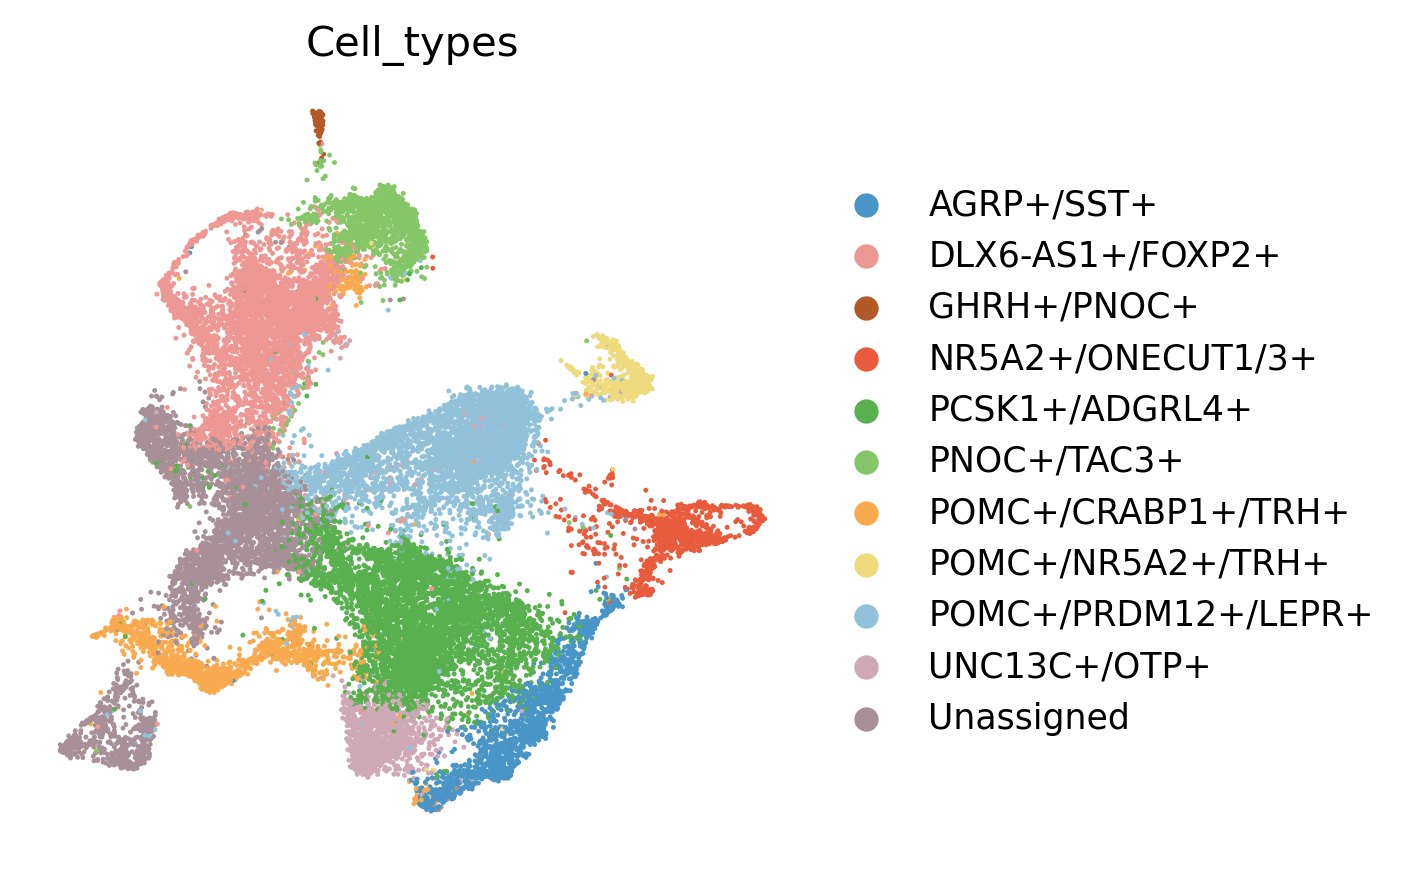

In [15]:
with plt.rc_context({ "figure.dpi": 250, "figure.figsize": (4,4)}):
    sc.pl.umap(adata_neurons, color=['Cell_types'],frameon=False, use_raw=False, size=8,
               ncols=4,cmap='jet', colorbar_loc=None,wspace=-0.02, palette=['#4a95c8','#ED9892','#B15A27','#e85b3d','#58b04e','#85C668','#FAAA4E','#EDDB7E','#91c2da','#D0A9B7','#a79098'])

In [16]:
adata_neurons.write('Data/adata_d50_d70_neurons.h5ad')

# MErge metadata

In [17]:
adata_d50_d70 = sc.read('Data/adata_d50_d70.h5ad')
adata_neurons = sc.read('Data/adata_d50_d70_neurons.h5ad')

In [19]:
adata_d50_d70.obs['Cell_types_2'] = adata_d50_d70.obs['Cell_types'].astype(str)
subtypes = pd.Series(list(adata_d50_d70[adata_d50_d70.obs_names.isin(adata_neurons.obs_names)].obs.index), dtype="category")
adata_d50_d70.obs['Cell_types_2'].loc[subtypes] = adata_neurons.obs['Cell_types'].astype(str)
adata_d50_d70.obs['Cell_types_2'] = adata_d50_d70.obs['Cell_types_2'].replace('ARC neurons', 'Unassigned')

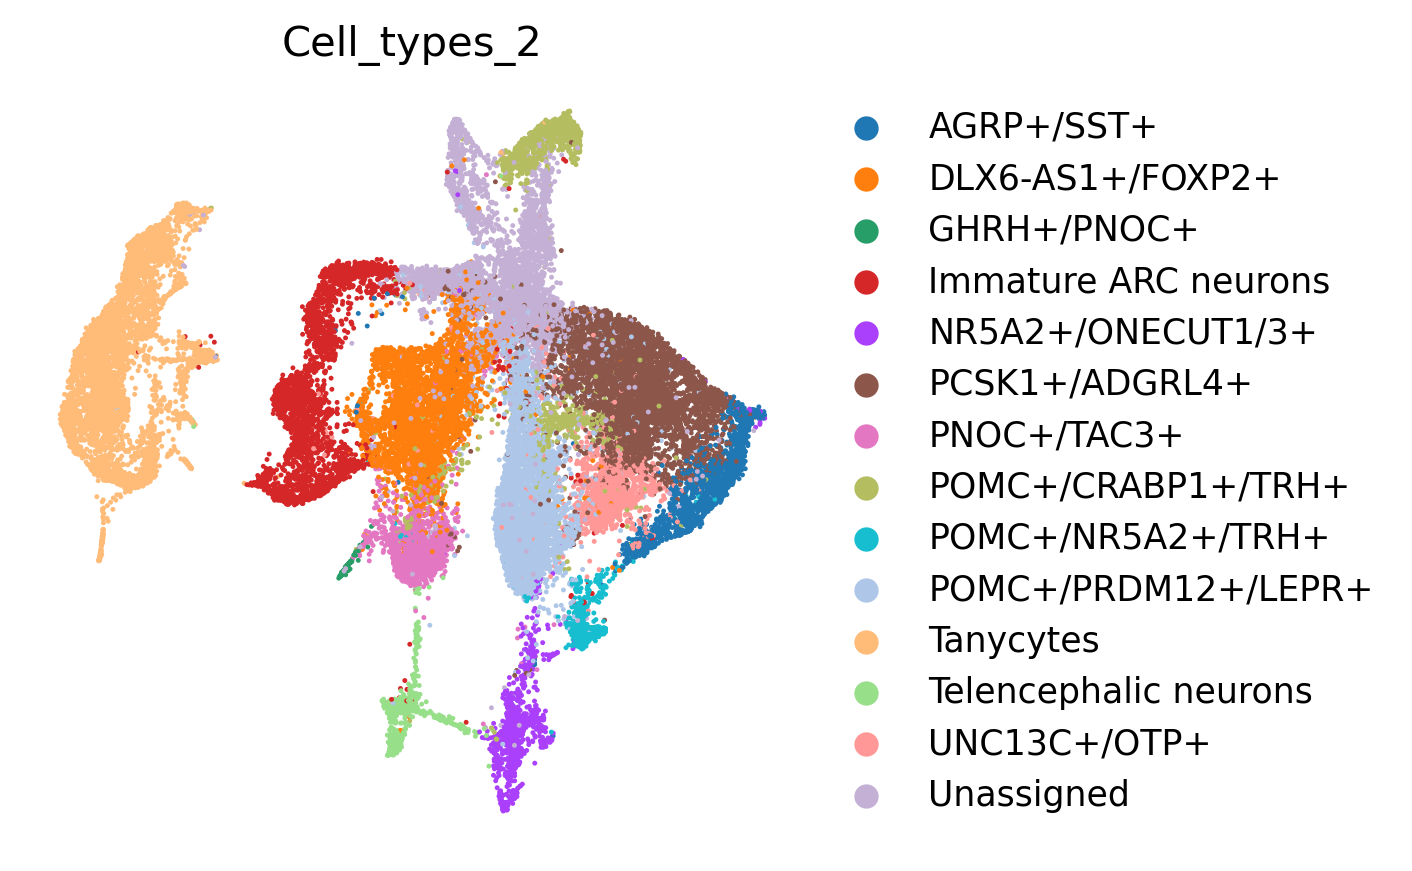

In [20]:
with plt.rc_context({ "figure.dpi": 250, "figure.figsize": (4,4)}):
    sc.pl.umap(adata_d50_d70, color=['Cell_types_2'],frameon=False, use_raw=False, size=8,
               ncols=4,cmap='jet', colorbar_loc=None,wspace=-0.02)

In [21]:
adata_d50_d70.write('Data/adata_d50_d70.h5ad')